In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/HRDataset_v14.csv")
print(df.head())
print(df.info())

              Employee_Name  EmpID  MarriedID  MaritalStatusID  GenderID  \
0       Adinolfi, Wilson  K  10026          0                0         1   
1  Ait Sidi, Karthikeyan     10084          1                1         1   
2         Akinkuolie, Sarah  10196          1                1         0   
3              Alagbe,Trina  10088          1                1         0   
4          Anderson, Carol   10069          0                2         0   

   EmpStatusID  DeptID  PerfScoreID  FromDiversityJobFairID  Salary  ...  \
0            1       5            4                       0   62506  ...   
1            5       3            3                       0  104437  ...   
2            5       5            3                       0   64955  ...   
3            1       5            3                       0   64991  ...   
4            5       5            3                       0   50825  ...   

      ManagerName  ManagerID RecruitmentSource PerformanceScore  \
0  Michael Albert  

In [ ]:
print(df.isnull().sum())

Employee_Name                   0
EmpID                           0
MarriedID                       0
MaritalStatusID                 0
GenderID                        0
EmpStatusID                     0
DeptID                          0
PerfScoreID                     0
FromDiversityJobFairID          0
Salary                          0
Termd                           0
PositionID                      0
Position                        0
State                           0
Zip                             0
DOB                             0
Sex                             0
MaritalDesc                     0
CitizenDesc                     0
HispanicLatino                  0
RaceDesc                        0
DateofHire                      0
DateofTermination             207
TermReason                      0
EmploymentStatus                0
Department                      0
ManagerName                     0
ManagerID                       8
RecruitmentSource               0
PerformanceSco

In [ ]:
df = df.drop(columns=['Employee_Name', 'EmpID', 'DOB', 'Zip', 'ManagerName', 'Sex'])

In [ ]:
print(df['DateofTermination'].dtype)


object


In [ ]:
status_mapping = df[['EmpStatusID', 'EmploymentStatus']].drop_duplicates()
print(status_mapping)

    EmpStatusID        EmploymentStatus
0             1                  Active
1             5  Voluntarily Terminated
8             3                  Active
15            4    Terminated for Cause
16            2                  Active
95            1    Terminated for Cause


In [ ]:
# Define attrition (binary target)
df['Attrition'] = df['EmpStatusID'].apply(lambda x: 1 if x in [4, 5] else 0)

# Drop the original EmploymentStatus columns if no longer needed
df = df.drop(columns=['EmploymentStatus', 'EmpStatusID'])


In [ ]:
print("Columns in the dataset:", df.columns)

Columns in the dataset: Index(['MarriedID', 'MaritalStatusID', 'GenderID', 'DeptID', 'PerfScoreID',
       'FromDiversityJobFairID', 'Salary', 'Termd', 'PositionID', 'Position',
       'State', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'Department',
       'ManagerID', 'RecruitmentSource', 'PerformanceScore',
       'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
       'LastPerformanceReview_Date', 'DaysLateLast30', 'Absences',
       'Attrition'],
      dtype='object')


In [ ]:
df = df.dropna(subset=['ManagerID'])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
print("Initial columns in the dataset:", df.columns)

# Convert 'DateofHire' and 'DateofTermination' to datetime and create numeric features
if 'DateofHire' in df.columns:
    df['DateofHire'] = pd.to_datetime(df['DateofHire'], errors='coerce')
if 'DateofTermination' in df.columns:
    df['DateofTermination'] = pd.to_datetime(df['DateofTermination'], errors='coerce')

# Create numeric features for hire and termination dates
if 'DateofHire' in df.columns and 'DateofTermination' in df.columns:
    df['DaysSinceHire'] = (df['DateofHire'] - df['DateofHire'].min()).dt.days
    df['DaysUntilTermination'] = (df['DateofTermination'].fillna(pd.to_datetime('today')) - df['DateofHire']).dt.days

# Drop original date columns after creating numeric features
df = df.drop(columns=['DateofHire', 'DateofTermination'], errors='ignore')

# Handle 'LastPerformanceReview_Date' column
if 'LastPerformanceReview_Date' in df.columns:
    # Convert to datetime
    df['LastPerformanceReview_Date'] = pd.to_datetime(df['LastPerformanceReview_Date'], errors='coerce')

    # Create a numeric feature (e.g., days since the last review date)
    df['DaysSinceLastPerformanceReview'] = (
        (pd.to_datetime('today') - df['LastPerformanceReview_Date']).dt.days
    )

    # Drop the original column
    df = df.drop(columns=['LastPerformanceReview_Date'], errors='ignore')

# Handle 'TermReason' as a categorical column
df['TermReason'] = df['TermReason'].fillna('Unknown')  # Fill N/A values with 'Unknown'

# Define all possible categories for TermReason
all_categories = ['N/A-StillEmployed', 'Layoff', 'Resignation', 'Termination', 'Unknown']

# Handle 'TermReason' column
df['TermReason'] = df['TermReason'].fillna('Unknown')  # Replace NaN with 'Unknown'

# Apply one-hot encoding for categorical columns
categorical_columns = ['Position', 'State', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino',
                       'RaceDesc', 'Department', 'RecruitmentSource', 'PerformanceScore', 'TermReason']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure 'TermReason_N/A-StillEmployed' exists
if 'TermReason_N/A-StillEmployed' not in df_encoded.columns:
    df_encoded['TermReason_N/A-StillEmployed'] = 0

# Fix any remaining nulls
df_encoded = df_encoded.fillna(0)

# Verify column
print("Unique values in 'TermReason_N/A-StillEmployed':", df_encoded['TermReason_N/A-StillEmployed'].unique())
print("Null values in 'TermReason_N/A-StillEmployed':", df_encoded['TermReason_N/A-StillEmployed'].isnull().sum())

# Define the target (Attrition) and features (X)
df_encoded['Attrition'] = df_encoded['Termd']  # Use Termd for binary target (1 for terminated, 0 for active)
X = df_encoded.drop(columns=['Attrition', 'Termd'], errors='ignore')  # Drop target columns
y = df_encoded['Attrition']  # Target variable

# Verify there are no datetime columns in X
print("Data types in X before training:")
print(X.dtypes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: Print unique TermReason values and dummy columns for debugging
print("Unique TermReason values before encoding:", df['TermReason'].unique())
print("Dummy columns after encoding:", df_encoded.columns)


Initial columns in the dataset: Index(['MarriedID', 'MaritalStatusID', 'GenderID', 'DeptID', 'PerfScoreID',
       'FromDiversityJobFairID', 'Salary', 'Termd', 'PositionID', 'Position',
       'State', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'Department',
       'ManagerID', 'RecruitmentSource', 'PerformanceScore',
       'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
       'LastPerformanceReview_Date', 'DaysLateLast30', 'Absences',
       'Attrition'],
      dtype='object')
Unique values in 'TermReason_N/A-StillEmployed': [ True False]
Null values in 'TermReason_N/A-StillEmployed': 0
Data types in X before training:
MarriedID                            int64
MaritalStatusID                      int64
GenderID                             int64
DeptID                               int64
PerfScoreID                          int64
                                     ...  
TermReason_performance  

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(rf_model, X, y, cv=5)
print("Cross-validation scores:", cross_val_scores)
print(f"Mean cross-validation score: {cross_val_scores.mean():.2f}")


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.00


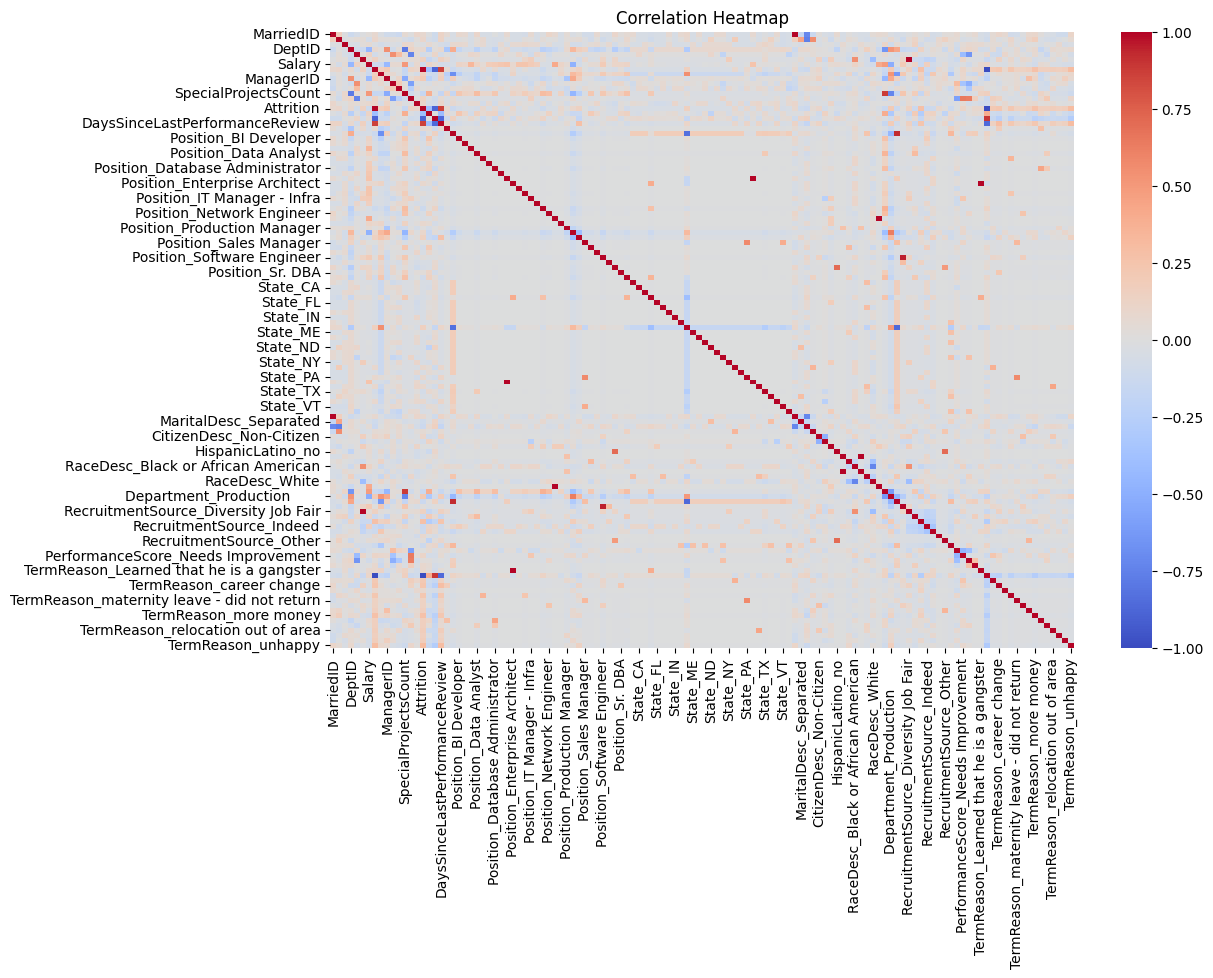

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for correlation between features and target
corr_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
print(df.isnull().sum())

MarriedID                         0
MaritalStatusID                   0
GenderID                          0
DeptID                            0
PerfScoreID                       0
FromDiversityJobFairID            0
Salary                            0
Termd                             0
PositionID                        0
Position                          0
State                             0
MaritalDesc                       0
CitizenDesc                       0
HispanicLatino                    0
RaceDesc                          0
TermReason                        0
Department                        0
ManagerID                         0
RecruitmentSource                 0
PerformanceScore                  0
EngagementSurvey                  0
EmpSatisfaction                   0
SpecialProjectsCount              0
DaysLateLast30                    0
Absences                          0
Attrition                         0
DaysSinceHire                     0
DaysUntilTermination        

In [ ]:
print(df)

     MarriedID  MaritalStatusID  GenderID  DeptID  PerfScoreID  \
0            0                0         1       5            4   
1            1                1         1       3            3   
2            1                1         0       5            3   
3            1                1         0       5            3   
4            0                2         0       5            3   
..         ...              ...       ...     ...          ...   
306          0                0         1       5            3   
307          0                0         0       5            1   
308          0                0         0       3            4   
309          0                0         0       3            3   
310          0                4         0       5            3   

     FromDiversityJobFairID  Salary  Termd  PositionID  \
0                         0   62506      0          19   
1                         0  104437      1          27   
2                         0   649

In [ ]:
# Initialize and train the logistic regression model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=42, max_iter=1000, penalty='l2')
lr_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_lr = lr_model.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")


Logistic Regression Accuracy: 1.00


In [ ]:
from sklearn.feature_selection import RFE


# Apply RFE to select important features
selector = RFE(lr_model, n_features_to_select=10)
X_selected = selector.fit_transform(X, y)

# Show selected features
selected_features = X.columns[selector.support_]
print("Selected features:", selected_features)


Selected features: Index(['DeptID', 'PositionID', 'ManagerID', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'Absences', 'DaysSinceHire',
       'DaysUntilTermination', 'DaysSinceLastPerformanceReview'],
      dtype='object')


In [ ]:
# Select the columns for the features that were selected by RFE
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_selected)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        24

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61

Confusion Matrix:
[[37  0]
 [ 0 24]]


In [ ]:
print(df.columns)

Index(['MarriedID', 'MaritalStatusID', 'GenderID', 'DeptID', 'PerfScoreID',
       'FromDiversityJobFairID', 'Salary', 'Termd', 'PositionID', 'Position',
       'State', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'TermReason', 'Department', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'DaysLateLast30', 'Absences', 'Attrition',
       'DaysSinceHire', 'DaysUntilTermination',
       'DaysSinceLastPerformanceReview'],
      dtype='object')


In [ ]:
# Check which features are not in the dataframe
missing_features = [col for col in selected_features if col not in df_encoded.columns]
print("Missing features:", missing_features)


Missing features: []


In [ ]:
print("DataFrame Columns:", df_encoded.columns.tolist())
print("Selected Features:", selected_features)


DataFrame Columns: ['MarriedID', 'MaritalStatusID', 'GenderID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID', 'Salary', 'Termd', 'PositionID', 'ManagerID', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences', 'Attrition', 'DaysSinceHire', 'DaysUntilTermination', 'DaysSinceLastPerformanceReview', 'Position_Administrative Assistant', 'Position_Area Sales Manager', 'Position_BI Developer', 'Position_BI Director', 'Position_CIO', 'Position_Data Analyst', 'Position_Data Analyst ', 'Position_Data Architect', 'Position_Database Administrator', 'Position_Director of Operations', 'Position_Director of Sales', 'Position_Enterprise Architect', 'Position_IT Director', 'Position_IT Manager - DB', 'Position_IT Manager - Infra', 'Position_IT Manager - Support', 'Position_IT Support', 'Position_Network Engineer', 'Position_President & CEO', 'Position_Principal Data Architect', 'Position_Production Manager', 'Position_Production Technician I', 'Position_Prod

In [ ]:
print(df_encoded[selected_features].isnull().sum())


DeptID                            0
PositionID                        0
ManagerID                         0
EngagementSurvey                  0
EmpSatisfaction                   0
SpecialProjectsCount              0
Absences                          0
DaysSinceHire                     0
DaysUntilTermination              0
DaysSinceLastPerformanceReview    0
dtype: int64


In [ ]:
print(df_encoded[selected_features].dtypes)


DeptID                              int64
PositionID                          int64
ManagerID                         float64
EngagementSurvey                  float64
EmpSatisfaction                     int64
SpecialProjectsCount                int64
Absences                            int64
DaysSinceHire                       int64
DaysUntilTermination                int64
DaysSinceLastPerformanceReview      int64
dtype: object


In [ ]:
for col in selected_features:
    if not pd.api.types.is_numeric_dtype(df_encoded[col]):
        print(f"Converting column '{col}' to numeric.")
        df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce').fillna(0)


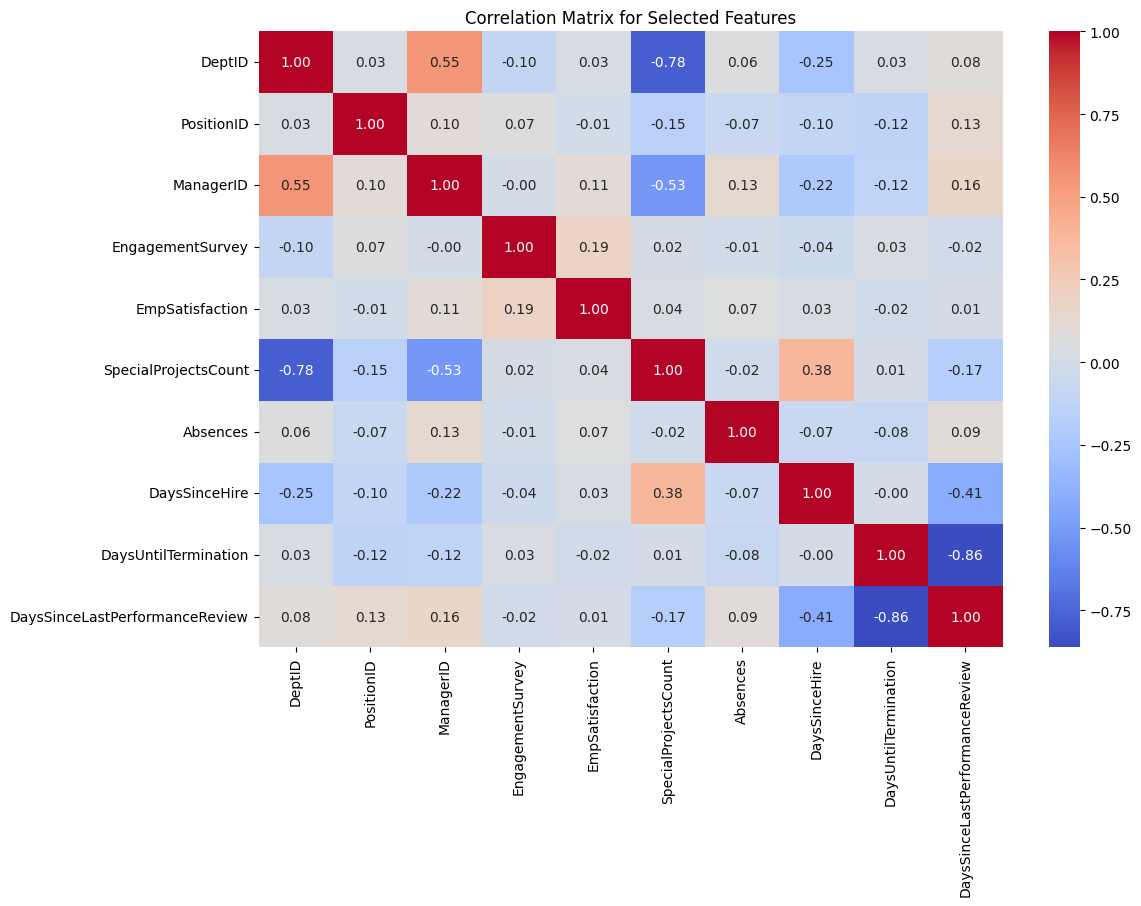

In [ ]:
corr_matrix = df_encoded[selected_features].corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for Selected Features")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split



In [ ]:
# Load sample dataset
data = load_iris()
X = data.data
y = data.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],     # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]       # Minimum samples required at a leaf node
}


In [ ]:
# Example code to fit GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
model = RandomForestClassifier()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Now access best parameters and estimator
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Best Estimator:", best_model)


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5)


In [ ]:
y_pred = best_model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


In [ ]:
print(df_encoded.columns)

Index(['MarriedID', 'MaritalStatusID', 'GenderID', 'DeptID', 'PerfScoreID',
       'FromDiversityJobFairID', 'Salary', 'Termd', 'PositionID', 'ManagerID',
       ...
       'TermReason_maternity leave - did not return',
       'TermReason_medical issues', 'TermReason_military',
       'TermReason_more money', 'TermReason_no-call, no-show',
       'TermReason_performance', 'TermReason_relocation out of area',
       'TermReason_retiring', 'TermReason_return to school',
       'TermReason_unhappy'],
      dtype='object', length=124)


In [ ]:
target_columns = [col for col in df_encoded.columns if col.startswith('TermReason_')]
df_encoded['Target'] = df_encoded[target_columns].idxmax(axis=1)

# Simplify the Target Column (removing 'TermReason_' prefix)
df_encoded['Target'] = df_encoded['Target'].str.replace('TermReason_', '')

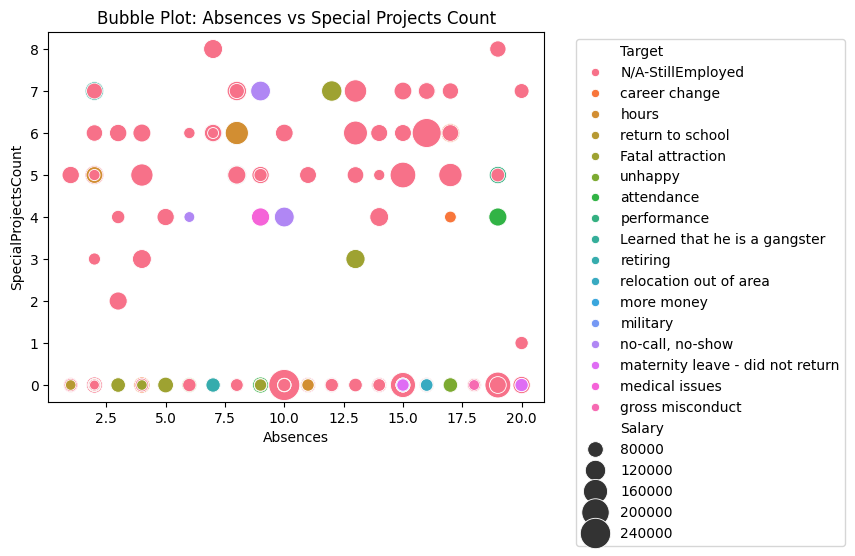

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Example Data
sns.scatterplot(x='Absences', y='SpecialProjectsCount', hue='Target',
                data=df_encoded, size='Salary', sizes=(50, 500))  # Adjust bubble size range

plt.title('Bubble Plot: Absences vs Special Projects Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


Scatter plot or bubble plot to identify relationships between features like Absences and SpecialProjectsCount.

<Axes: xlabel='DaysSinceHire', ylabel='DaysUntilTermination'>

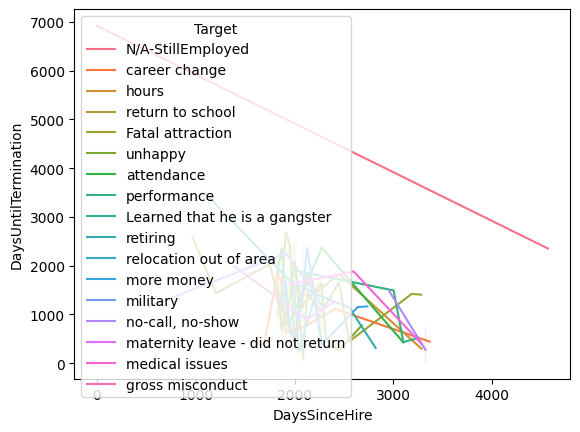

In [ ]:
sns.lineplot(x='DaysSinceHire', y='DaysUntilTermination', hue='Target', data=df_encoded)